### 1. Import Packages

In [1]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.impute import KNNImputer

# Librerie per la Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per il Machine Learning
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la PCA
from sklearn.decomposition import PCA

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [2]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M172,M173,M174,M175,M176,M177,M178,M179,M180,M181
0,Plasma,Adenocarcinoma,Former,F,194,168,77,105985,118,15489,...,195,1606,300,108,7203,43,59,1009,383,68
1,Plasma,Adenocarcinoma,Former,F,215,143,154,100462,133,13534,...,184,364,1364,160,11910,82,99,136,1021,165
2,Plasma,Adenocarcinoma,Current,F,104,67,45,75301,94,7390,...,189,157,884,73,6372,59,35,115,530,72
3,Plasma,Adenocarcinoma,Current,M,360,642,82,42097,84,50943,...,320,1621,461,104,14011,69,86,845,1309,127
4,Plasma,Adenocarcinoma,Current,M,96,137,95,112346,168,41987,...,84,769,266,158,18140,40,87,1213,1037,149


### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [3]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Eliminiamo le righe con valori nulli all'interno delle colonne "HealthState" e "Sex"
df = df.dropna(subset=["HealthState", "Sex"])

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M173,M174,M175,M176,M177,M178,M179,M180,M181,Output
0,Plasma,Adenocarcinoma,0,1,194,168,77,105985,118,15489,...,1606,300,108,7203,43,59,1009,383,68,1
1,Plasma,Adenocarcinoma,0,1,215,143,154,100462,133,13534,...,364,1364,160,11910,82,99,136,1021,165,1
2,Plasma,Adenocarcinoma,1,1,104,67,45,75301,94,7390,...,157,884,73,6372,59,35,115,530,72,1
3,Plasma,Adenocarcinoma,1,0,360,642,82,42097,84,50943,...,1621,461,104,14011,69,86,845,1309,127,1
4,Plasma,Adenocarcinoma,1,0,96,137,95,112346,168,41987,...,769,266,158,18140,40,87,1213,1037,149,1


### 3. Extract X & Y

In [4]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

In [5]:
# KNNImputer
imputer_knn = KNNImputer()
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_13629/4178831705.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 3.2 Train-test Split

In [6]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Initial Model Build

In [7]:
# Definiamo il modello MultinomialNB con gli iperparametri di default
model = MultinomialNB()

# Addestriamo il modello
model.fit(X_train_knn, y_train_knn)

# Eseguiamo le previsioni sui dati di test
y_pred_knn = model.predict(X_test_knn)

### 5. Initial Model Evalutation

In [8]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.7272727272727273
Precision: 0.8333333333333334
Recall: 0.5882352941176471
F1-score: 0.6896551724137931
ROC AUC: 0.7316176470588236


Abbiamo un'accuratezza del 72%, una Precision di 83% e una Recall del 58%. Proviamo con la K-Fold Cross Validation.

In [9]:
# Testiamo diverse configurazioni di K
max = 0
k_best = 0
for k in range(5, 11): 
    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    model = MultinomialNB()
    scores = cross_val_score(model, X_knn, y, cv=kfolds)
    mean = np.mean(scores)
    if mean > max: 
        max = mean
        k_best = k
    print(f"K={k}, Accuratezza Media: {mean}")
    
print("-------------------------------------------")
print(f"K ottimale: {k_best}")
print(f"Accuratezza media massima: {max}")

K=5, Accuratezza Media: 0.6871212121212121
K=6, Accuratezza Media: 0.6501322751322751
K=7, Accuratezza Media: 0.6806418219461696
K=8, Accuratezza Media: 0.6428571428571429
K=9, Accuratezza Media: 0.6569200779727095
K=10, Accuratezza Media: 0.6742647058823529
-------------------------------------------
K ottimale: 5
Accuratezza media massima: 0.6871212121212121


Abbiamo ottenuto le prestazioni migliori con un numero di fold pari a 10.

In [10]:
# Creiamo l'oggetto K-Fold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

### 6.1 MultinomialNB Hyperparameters Optimization

In [11]:
# Creiamo un nuovo modello MultinoimialNB
model_2 = MultinomialNB()

# Definiamo la griglia con i parametri da testare
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

# Creiamo l'oggetto GridSearchCV
grid_search_model = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)
grid_search_model.fit(X_knn, y)

# Visualizziamo i risultati
best_params = grid_search_model.best_params_
print("Iperparametri migliori:", best_params)

Iperparametri migliori: {'alpha': 0.1}


In [12]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = MultinomialNB(**best_params)

In [13]:
# Valutiamo le prestazioni del modello con gli iperparametri ottimizzati
best_model.fit(X_train_knn, y_train_knn)
y_pred_knn = best_model.predict(X_test_knn)

# Calcoliamo le metriche
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

# Visualizziamo le metriche
print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.7272727272727273
Precision: 0.8333333333333334
Recall: 0.5882352941176471
F1-score: 0.6896551724137931
ROC AUC: 0.7316176470588236


In [14]:
# K-Fold Cross Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')
print(f'Standard Deviation: {scores.std()}')

Accuratezza media: 0.6871212121212121
Standard Deviation: 0.10022787397607058


### 6.2 KNNImputer Optimization

In [15]:
# Definiamo il range di valori di n_neighbors da testare
n_neighbors_values = np.arange(1, 11)

# Creiamo un oggetto KNNImputer
max_nb = 0 
k_nb = 0

for n_neighbors in n_neighbors_values:

    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_imputed = imputer.fit_transform(X)
    scores = cross_val_score(best_model, X_imputed, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_nb: 
        max_nb = mean
        k_nb = n_neighbors 

    print(f"K={n_neighbors}, Accuratezza Media: {mean}")

print(f"Numero di neighbors ottimale: {k_nb}")
print(f"Accuratezza media ottimale: {max_nb}")

K=1, Accuratezza Media: 0.6871212121212121
K=2, Accuratezza Media: 0.6871212121212121
K=3, Accuratezza Media: 0.6871212121212121
K=4, Accuratezza Media: 0.6871212121212121
K=5, Accuratezza Media: 0.6871212121212121
K=6, Accuratezza Media: 0.6871212121212121
K=7, Accuratezza Media: 0.6871212121212121
K=8, Accuratezza Media: 0.6871212121212121
K=9, Accuratezza Media: 0.6871212121212121
K=10, Accuratezza Media: 0.6871212121212121
Numero di neighbors ottimale: 1
Accuratezza media ottimale: 0.6871212121212121


Possiamo notare che il numero di neighbors non influenza le prestazioni del modello.

### 7. Feature Selection

In [16]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

K=2, Accuratezza Media: 0.6375
K=3, Accuratezza Media: 0.5820075757575758
K=4, Accuratezza Media: 0.5882575757575758
K=5, Accuratezza Media: 0.6501893939393939
K=6, Accuratezza Media: 0.6625
K=7, Accuratezza Media: 0.6746212121212121
K=8, Accuratezza Media: 0.6806818181818182
K=9, Accuratezza Media: 0.656439393939394
K=10, Accuratezza Media: 0.65
K=11, Accuratezza Media: 0.656060606060606
K=12, Accuratezza Media: 0.6685606060606061
K=13, Accuratezza Media: 0.6625
K=14, Accuratezza Media: 0.6685606060606061
K=15, Accuratezza Media: 0.66875
K=16, Accuratezza Media: 0.675
K=17, Accuratezza Media: 0.681060606060606
K=18, Accuratezza Media: 0.675
K=19, Accuratezza Media: 0.6935606060606061
K=20, Accuratezza Media: 0.6935606060606061
K=21, Accuratezza Media: 0.687310606060606
K=22, Accuratezza Media: 0.6933712121212121
K=23, Accuratezza Media: 0.6996212121212121
K=24, Accuratezza Media: 0.6996212121212121
K=25, Accuratezza Media: 0.6996212121212121
K=26, Accuratezza Media: 0.6935606060606061

In [17]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.6996212121212121


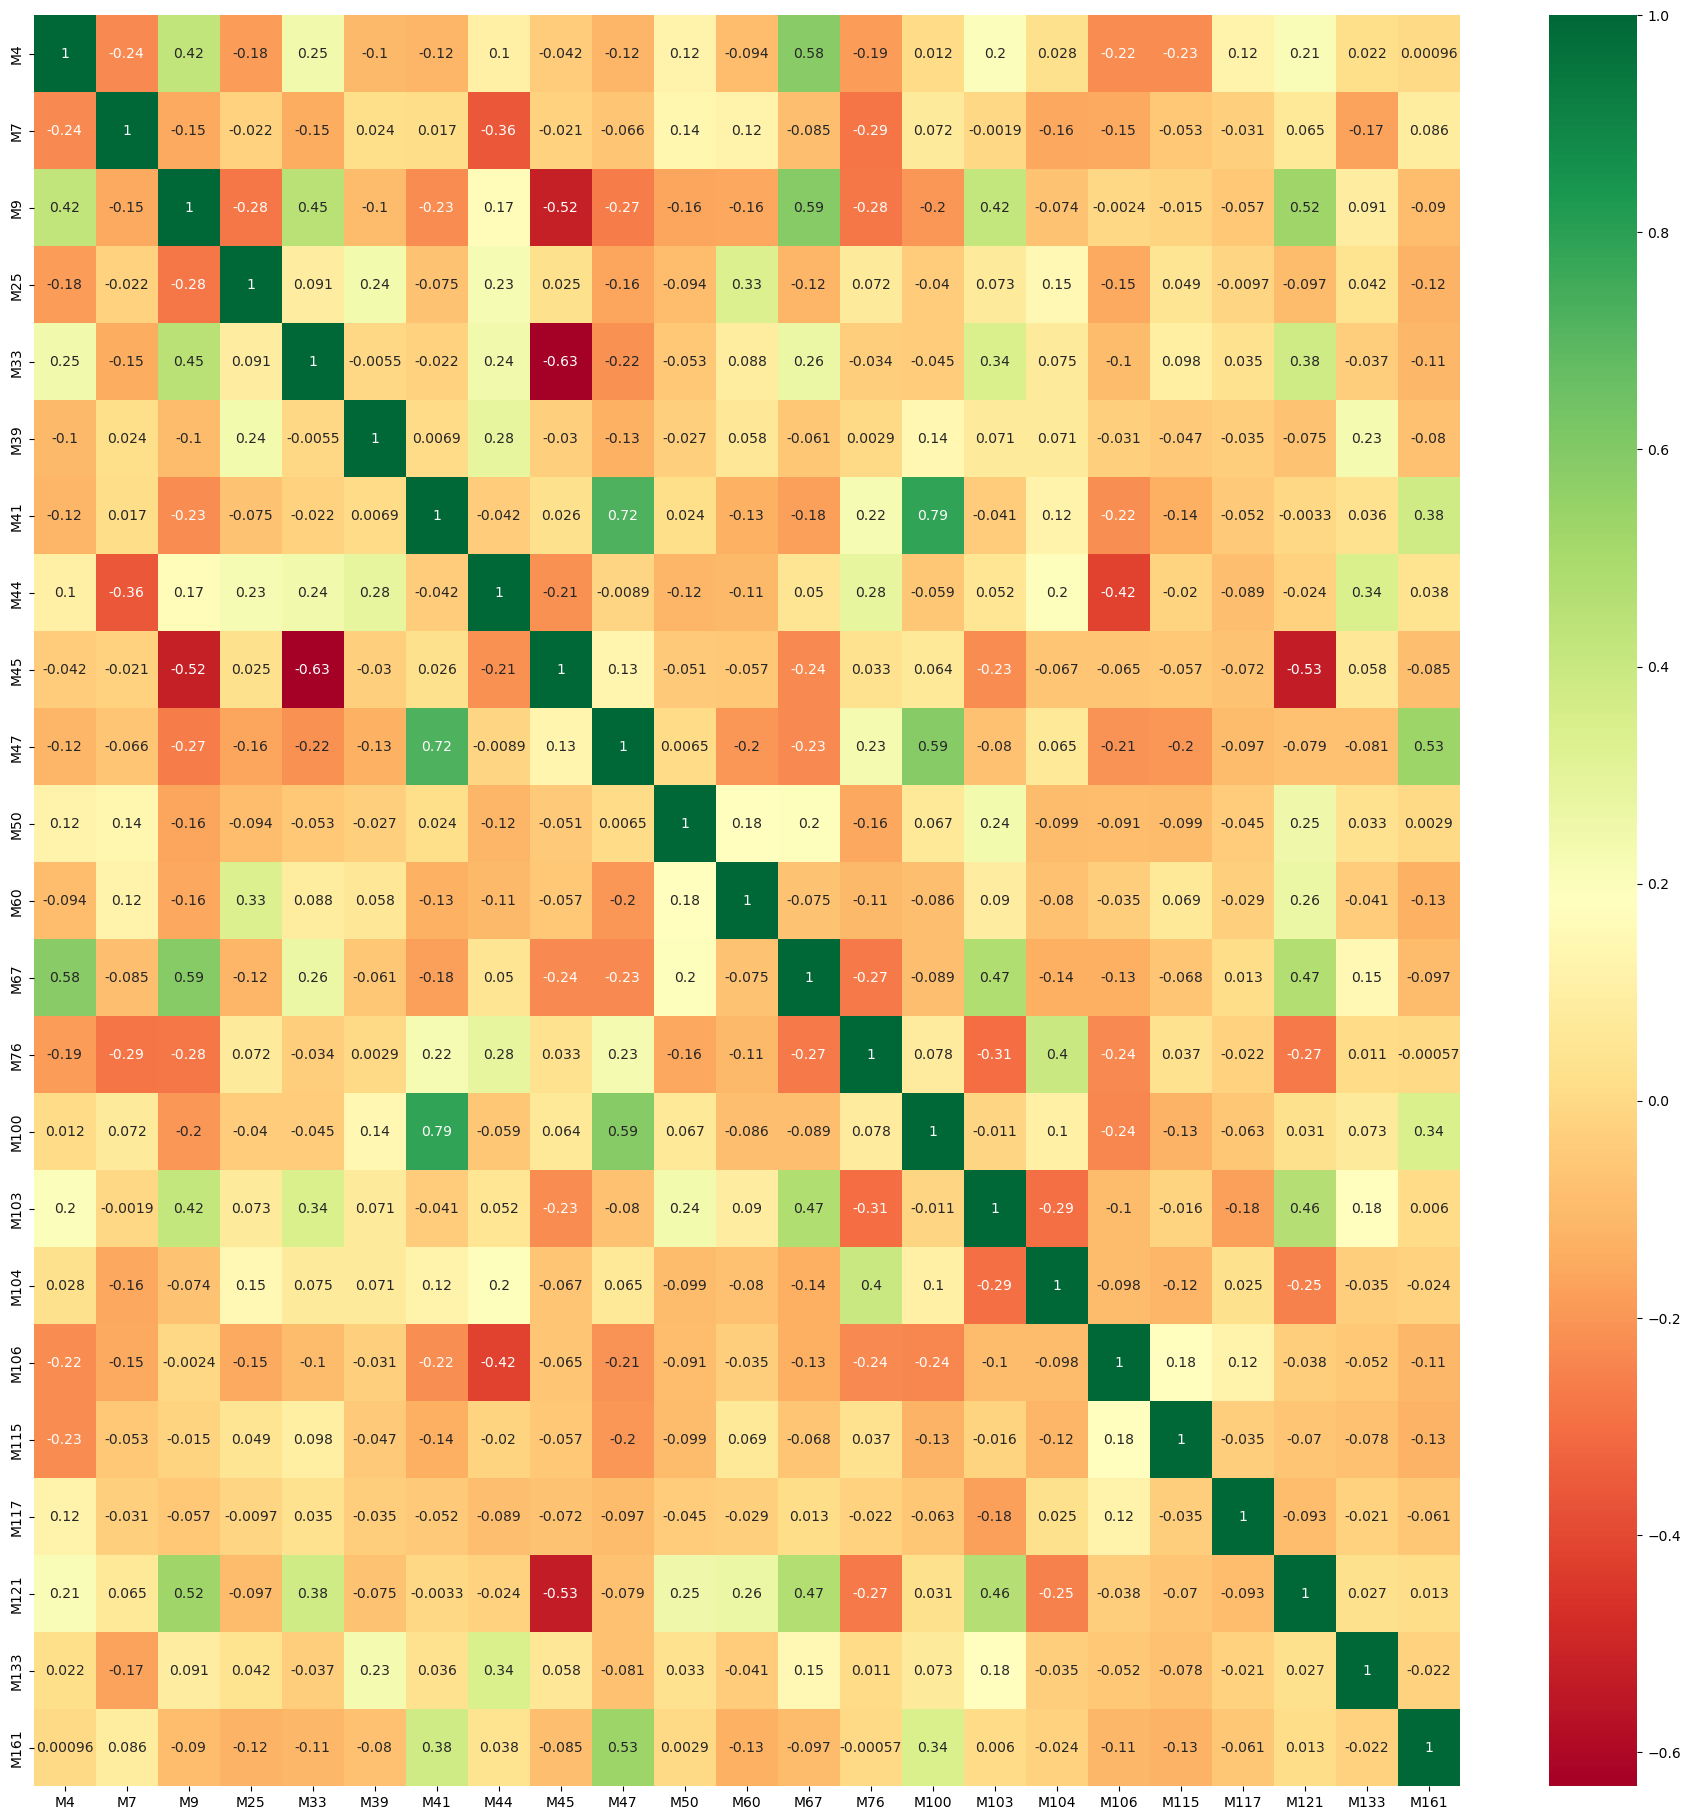

In [18]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 9. Results

Visualizziamo i risultati migliori.

In [22]:
# Numero ottimale di fold
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

# Modello BernoulliNB con gli iperparametri ottimizzati
model = MultinomialNB(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
y_pred = cross_val_predict(model, X_top, y, cv=kfolds, method='predict_proba')

# Scegliamo na soglia (threshold) per trasformare le probabilità in etichette binarie
threshold = 0.5
y_pred = (y_pred[:, 1] > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
f1 = metrics.f1_score(y, y_pred)
roc_auc = metrics.roc_auc_score(y, y_pred)

In [23]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

print("------------------------")
print(f'Matrice di confusione:\n {metrics.confusion_matrix(y, y_pred)}')
print("------------------------")
print(f'Migliori iperparametri:')
for h in best_params:
    print(f'- {h}: {best_params[h]}')
print("------------------------")
print(f'Features selezionate: {len(best_features)}')
print("------------------------")

------------------------
Accuracy: 0.6994
Precision: 0.8400
Recall: 0.6300
F1-score: 0.7200
ROC AUC: 0.7198
------------------------
Matrice di confusione:
 [[51 12]
 [37 63]]
------------------------
Migliori iperparametri:
- alpha: 0.1
------------------------
Features selezionate: 23
------------------------
